In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import random

# Set random seed for reproducibility
manualSeed = 2020
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  2020


In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cpu


In [4]:
# hyper-parameter
image_size = 64
batch_size = 64

In [5]:
# standardizer
standardizer = transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0.5,
                                                        std=0.5)])

# CIFAR_10 dataset
train_data = dsets.MNIST(root='../data/', train=True, transform=standardizer, download=True)

100.0%


Extracting ../data/MNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST\raw



100.0%


Extracting ../data/MNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST\raw



100.0%


Extracting ../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST\raw



100.0%

Extracting ../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST\raw



In [6]:
# Data loader
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

In [7]:
# function for visualization
def tc_imshow(img, lbl=""):
    if img.size(0) == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(img, (1, 2, 0)))

    plt.title(lbl)
    plt.axis('off')

FileNotFoundError: [Errno 2] No such file or directory: '../result/GAN/2-DCGAN/1-dataloader-example.png'

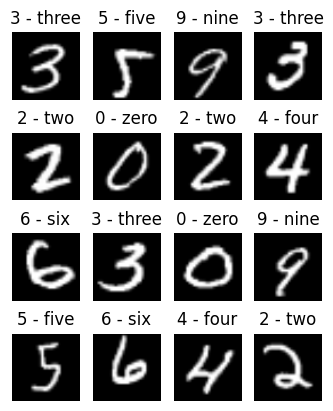

In [8]:
# visualize

# visualize
mini_batch_img, mini_batch_lbl = next(iter(train_data_loader))

plt.figure(figsize=(4,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    tc_imshow(img=mini_batch_img[i] /2+0.5 ,
              lbl=train_data.classes[mini_batch_lbl[i].numpy()])
    plt.axis('off')

plt.savefig('../result/GAN/2-DCGAN/1-dataloader-example.png', dpi=300)

In [9]:
# hyper-parameter
dim_noise = 100

In [10]:
# Random sampling from uniform distribution
def random_sample_z_space(batch_size=1, dim_noise=100):
    return torch.rand(batch_size, dim_noise, 1, 1, device=device)

In [11]:
# hyper-paremeters
dim_G_last2_channel = 64
dim_output = mini_batch_img.size(1)

In [12]:
def initialize_weights(model):
    class_names = model.__class__.__name__

    if class_names.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif class_names.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                    # 100x1 z 1D vector에서 2D vector로의 변환이 없는 이유: 애초에 z random sampling 시 1x1 matrix 형태로 sampling 하면 됨.
                    nn.ConvTranspose2d(in_channels=dim_noise,
                                       out_channels=dim_G_last2_channel*8,
                                       kernel_size=4, # s
                                       stride=1,
                                       padding=0, # s
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*8),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*8,
                                       out_channels=dim_G_last2_channel*4,
                                       kernel_size=4, # s
                                       stride=2,
                                       padding=1, # s
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*4),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*4,
                                       out_channels=dim_G_last2_channel*2,
                                       kernel_size=4, # s
                                       stride=2,
                                       padding=1, # s
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*2),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*2,
                                       out_channels=dim_G_last2_channel,
                                       kernel_size=4, # s
                                       stride=2,
                                       padding=1, # s
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel,
                                       out_channels=dim_output,
                                       kernel_size=4, # s
                                       stride=2,
                                       padding=1, # s
                                       bias=False),
                    nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)

        return img

In [14]:
# visualize
utils.save_image(Generator(z)[:25].cpu().detach(), "../result/GAN/2-DCGAN/2-G(z).png", nrow=5, normalize=True)

NameError: name 'G' is not defined

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=dim_output,
                      out_channels=dim_G_last2_channel,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=dim_G_last2_channel,
                      out_channels=dim_G_last2_channel*2,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=dim_G_last2_channel*2,
                      out_channels=dim_G_last2_channel*4,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=dim_G_last2_channel*4,
                      out_channels=dim_G_last2_channel*8,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=dim_G_last2_channel*8,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.Sigmoid()
        )


    def forward(self, img):
        check_validity = self.model(img)

        return check_validity

In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(initialize_weights)
discriminator.apply(initialize_weights)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=

In [17]:
# hyper-parameter
learning_rate = 0.0002
beta1 = 0.5

In [18]:
adversarial_loss = nn.BCELoss()

In [19]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [20]:
# hyper-parameters
num_epochs = 200
interval_save_img = 1000

In [21]:
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor

In [25]:
losses = []

for idx_epoch in range(num_epochs):
    for idx_batch, (imgs, _) in enumerate(train_data_loader):
        # Ground truth variables indicating real/fake
        real_ground_truth = Variable(Tensor(imgs.size(0), 1, 1, 1).fill_(1.0), requires_grad=False)
        fake_ground_truth = Variable(Tensor(imgs.size(0), 1, 1, 1).fill_(0.0), requires_grad=False)

        # Real image
        real_imgs = Variable(imgs.type(Tensor))

        #####################
        # Train Generator

        optimizer_G.zero_grad()

        # Random sample noise
        z = random_sample_z_space(imgs.size(0))

        # Generate image
        gen_imgs = generator(z)

        # Generator's loss: loss between D(G(z)) and real ground truth
        loss_G = adversarial_loss(discriminator(gen_imgs), real_ground_truth)

        loss_G.backward()
        optimizer_G.step()


        #####################
        # Train Discriminator

        optimizer_D.zero_grad()

        loss_real = adversarial_loss(discriminator(real_imgs), real_ground_truth)
        loss_fake = adversarial_loss(discriminator(gen_imgs.detach()), fake_ground_truth)
        loss_D = (loss_real+loss_fake)/2

        loss_D.backward()
        optimizer_D.step()


        #####################
        # archieve loss
        losses.append([loss_G.item(), loss_D.item()])

        # Print progress
        if idx_batch % 10 == 0:
            print("[Epoch {}/{}] [Batch {}/{}] loss_G: {:.6f}, loss_D: {:.6f}".format(idx_epoch, num_epochs,
                                                                                      idx_batch, len(train_data_loader),
                                                                                      loss_G, loss_D))

        batches_done = idx_epoch * len(train_data_loader) + idx_batch
        # if batches_done % interval_save_img == 0:
        #     utils.save_image(gen_imgs.data[:25], "/result/GAN/2-DCGAN/3-{}.png".format(batches_done), nrow=5, normalize=True)
            
            

[Epoch 0/200] [Batch 0/938] loss_G: 10.750132, loss_D: 0.002309
[Epoch 0/200] [Batch 10/938] loss_G: 7.193318, loss_D: 0.035244
[Epoch 0/200] [Batch 20/938] loss_G: 10.525328, loss_D: 0.048677
[Epoch 0/200] [Batch 30/938] loss_G: 15.985373, loss_D: 0.059445
[Epoch 0/200] [Batch 40/938] loss_G: 13.128920, loss_D: 0.011806
[Epoch 0/200] [Batch 50/938] loss_G: 15.632998, loss_D: 0.034585
[Epoch 0/200] [Batch 60/938] loss_G: 26.880184, loss_D: 0.197895
[Epoch 0/200] [Batch 70/938] loss_G: 25.988544, loss_D: 0.392336
[Epoch 0/200] [Batch 80/938] loss_G: 0.469042, loss_D: 0.515672
[Epoch 0/200] [Batch 90/938] loss_G: 11.599687, loss_D: 0.005970
[Epoch 0/200] [Batch 100/938] loss_G: 7.403642, loss_D: 0.000452
[Epoch 0/200] [Batch 110/938] loss_G: 4.632321, loss_D: 0.007026


KeyboardInterrupt: 